# dataset/ingest

In [1]:
from abcli.modules import objects
from abcli import fullname
from abcli.plugins import cache
from roofAI.dataset.ingest.AIRS import ingest_AIRS
from abcli import string
from abcli.plugins import seed
import abcli.logging
import logging

logger = logging.getLogger()

logger.info(f"{fullname()}, built on {string.pretty_date()}")

Found credentials in shared credentials file: ~/.aws/credentials
/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
abcli-7.2384.1-2023-06-aws-batch-a, built on 21 October 2023, 14:58:39


In [2]:
cache_object_name = cache.read("roofAI_ingest_AIRS_cache")
ingest_object_name = objects.unique_object("roofAI-AIRS-ingest")

📂 roofAI-AIRS-ingest-2023-10-21-14-58-39-19265


ingesting AIRS roofAI_ingest_AIRS_cache_2023-10-15-15-53-41-09195 -test X 10 + train X 10 + val X 10-360x480-@50%-> roofAI-AIRS-ingest-2023-10-21-14-58-39-19265
RoofAIDataset[kind:DatasetKind.AIRS,source:AIRS](roofAI_ingest_AIRS_cache_2023-10-15-15-53-41-09195): 3 subset(s): 95 X test + 857 X train + 94 X val - 2 class(es): other, roof
RoofAIDataset[kind:DatasetKind.CAMVID,source:AIRS](roofAI-AIRS-ingest-2023-10-21-14-58-39-19265): 3 subset(s): 0 X test + 0 X train + 0 X val - 2 class(es): other, roof
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-58-39-19265/SegNet-Tutorial/CamVid/test)
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-58-39-19265/SegNet-Tutorial/CamVid/testannot)
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-58-39-19265/SegNet-Tutorial/CamVid/train)
abcli.path.create(/Users/kamangir/storage/abcli/roofAI-AIRS-ingest-2023-10-21-14-58-39-19265/SegNet-Tutorial/CamVid/train

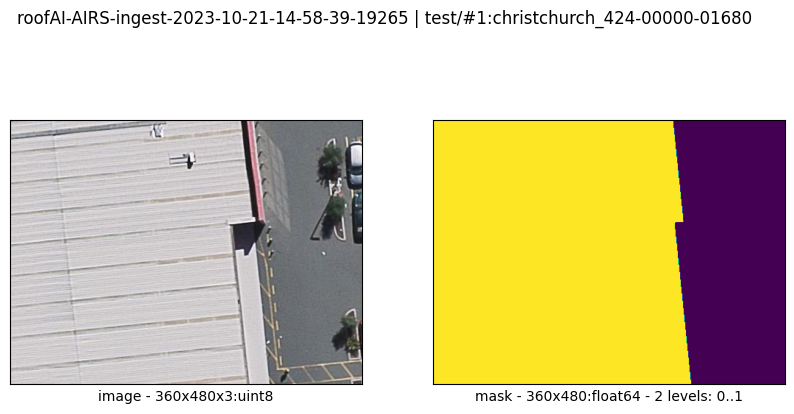

In [3]:
assert ingest_AIRS(
    cache_path=objects.object_path(cache_object_name),
    ingest_path=objects.object_path(ingest_object_name),
    counts={
        "test": 10,
        "train": 10,
        "val": 10
    },
    log=True,
    in_notebook=True,
)

In [4]:
seed.log(ingest_object_name)

abcli select roofAI-AIRS-ingest-2023-10-21-14-58-39-19265; open .


In [5]:
# END